C:\Users\Will\AppData\Local\Temp\ipykernel_23056\2190239697.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  incident.groupby(df['people_id']).shift(-1).fillna(False) |
C:\Users\Will\AppData\Local\Temp\ipykernel_23056\2190239697.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  incident.groupby(df['people_id']).shift(-2).fillna(False) |
C:\Users\Will\AppData\Local\Temp\ipykernel_23056\2190239697.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_obje

Accuracy: 0.66

Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.23      0.29        60
           1       0.72      0.84      0.78       140

    accuracy                           0.66       200
   macro avg       0.55      0.54      0.53       200
weighted avg       0.62      0.66      0.63       200



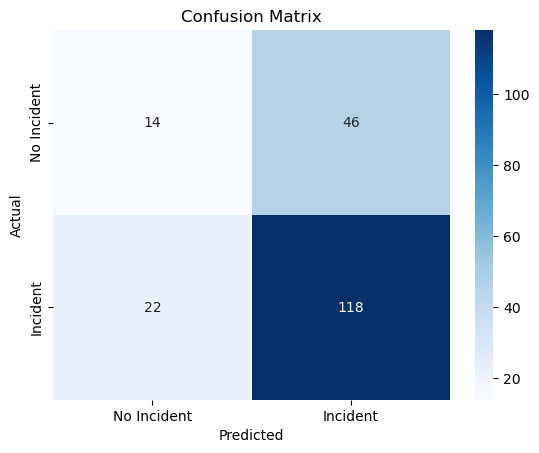

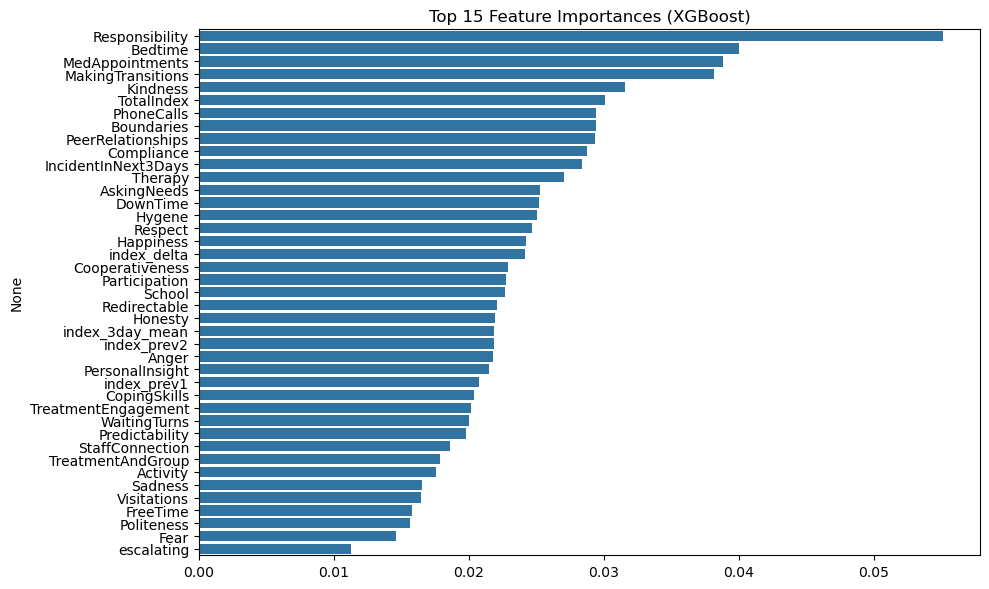

In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Load your dataset
file_path = Path.cwd().parent / "Data" / "fake_structured.csv"
df = pd.read_csv(file_path)  # replace with your actual dataset path
df = df.sort_values(by=['people_id', 'actual_date'])

df['index_prev1'] = df.groupby('people_id')['TotalIndex'].shift(1)
df['index_prev2'] = df.groupby('people_id')['TotalIndex'].shift(2)

df['index_3day_mean'] = df.groupby('people_id')['TotalIndex'].rolling(3).mean().reset_index(0, drop=True)
df['index_delta'] = df['TotalIndex'] - df['index_prev1']
df['escalating'] = (df['index_delta'] > 0) & (df['index_prev1'] > df['index_prev2'])
# Maybe try this as Target
incident = df['IncidentNextDay'].astype(bool)
df['IncidentInNext3Days'] = (
    incident.groupby(df['people_id']).shift(-1).fillna(False) |
    incident.groupby(df['people_id']).shift(-2).fillna(False) |
    incident.groupby(df['people_id']).shift(-3).fillna(False)
).astype(int)

# Prepare data
df = df.iloc[:, 6:]  # Trim off metadata
target_col = 'IncidentNextDay'
feature_cols = [col for col in df.columns if col != target_col]

X = df[feature_cols]
y = df[target_col]

smote = SMOTE(random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Initialize and train XGBoost classifier
clf = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # Adjust for class imbalance
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

clf.fit(X_train_bal, y_train_bal)

# Predict probabilities and apply custom threshold
y_probs = clf.predict_proba(X_test)[:, 1]
y_pred_custom = (y_probs > 0.3).astype(int)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_custom))
print("\nClassification Report:\n", classification_report(y_test, y_pred_custom))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_custom)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Incident', 'Incident'],
            yticklabels=['No Incident', 'Incident'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance Plot
importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Top 15 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()